---
title: "Module 05: Lab 02"
subtitle: "Regression Modeling on Employment Data"
author:
  - name: Norah Jones
    affiliations:
      - id: cmu
        name: Carnegie Mellon University
        city: Pittsburgh
        state: PA
      - id: chicago
        name: University of Chicago
        city: Chicago
        state: IL
  - name: John Hamm
    affiliations:
      - ref: cmu
      - name: University of California, San Diego
        city: San Diego
        state: CA
number-sections: true
date: "2024-11-21"
format:
  html:
    theme: cerulean
    toc: true
    toc-depth: 2
date-modified: today
date-format: long
execute: 
  echo: false
  eval: false
  freeze: auto
---

# Objectives {.unnumbered}

1. Use **PySpark** to process the Lightcast dataset.
2. Engineer features from structured columns for salary prediction.
3. Train **Linear Regression model**.
4. Evaluate models using **RMSE** and **R²**.
5. Visualize predictions using diagnostic plots.
6. Push work to GitHub and submit the repository link.

# Setup {.unnumbered}

The instruction below provides you with general keywords for columns used in the lightcast file. See the data schema generated after the load dataset code above to use proper column name. For visualizations, tables, or summaries, please **customize colors, fonts, and styles** as appropriate to avoid a **2.5-point deduction**. Also, **provide a two-sentence explanation** describing key insights drawn from each section's code and outputs. 

1. Follow the steps below as necessary, use your best judgement in importing/installing/creating/saving files as needed.
2. Create a new Jupyter Notebook in your `ad688-sp25-lab08` directory named `lab08_yourname.ipynb`, if the file exists make sure to change the name.
3. Use your **EC2 instance** for this lab.
4. Ensure the `lightcast_data.csv` file is available on the EC2 instance. if not then **Download the dataset**
5. **Add the dataset to `.gitignore`** to avoid pushing large files to GitHub. Open your `.gitignore` file and add:
6. Make sure to create a virtual environment and install the required Python libraries if needed, don't forget to activate it:
7. Install the required Python libraries if needed, you can also use the given requirement file to install the packages to the virtual environment:

```bash
python3 -m venv .venv
source .venv/bin/activate
gdown https://drive.google.com/uc?id=1V2GCHGt2dkFGqVBeoUFckU4IhUgk4ocQ
echo "lightcast_job_postings.csv" >> .gitignore
pip install -r requirements.txt
```


# Load the Dataset
1. **Load the Raw Dataset**:
   - Use Pyspark to the `lightcast_data.csv` file into a DataFrame:
   - You can reuse the previous code. 
   - [Copying code from your friend constitutes plagiarism. DO NOT DO THIS]{.uured-bold}.

In [8]:
from pyspark.sql import SparkSession
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook"

# Initialize Spark Session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

# Load Data
df = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").option("escape", "\"").csv("lightcast_job_postings.csv")

# Show Schema and Sample Data
print("---This is Diagnostic check, No need to print it in the final doc---")

df.printSchema() # comment this line when rendering the submission
df.show(5)

---This is Diagnostic check, No need to print it in the final doc---
root
 |-- ID: string (nullable = true)
 |-- LAST_UPDATED_DATE: date (nullable = true)
 |-- LAST_UPDATED_TIMESTAMP: timestamp (nullable = true)
 |-- DUPLICATES: integer (nullable = true)
 |-- POSTED: date (nullable = true)
 |-- EXPIRED: date (nullable = true)
 |-- DURATION: integer (nullable = true)
 |-- SOURCE_TYPES: string (nullable = true)
 |-- SOURCES: string (nullable = true)
 |-- URL: string (nullable = true)
 |-- ACTIVE_URLS: string (nullable = true)
 |-- ACTIVE_SOURCES_INFO: string (nullable = true)
 |-- TITLE_RAW: string (nullable = true)
 |-- BODY: string (nullable = true)
 |-- MODELED_EXPIRED: date (nullable = true)
 |-- MODELED_DURATION: integer (nullable = true)
 |-- COMPANY: integer (nullable = true)
 |-- COMPANY_NAME: string (nullable = true)
 |-- COMPANY_RAW: string (nullable = true)
 |-- COMPANY_IS_STAFFING: boolean (nullable = true)
 |-- EDUCATION_LEVELS: string (nullable = true)
 |-- EDUCATION_LEVELS

# Feature Engineering

Feature Engineering is a crucial step in preparing your data for machine learning. In this lab, we will focus on the following tasks:

1. **Drop rows with missing values** in the target variable and key features.
2. By now you are already familiar with the code and the data. Based on your understanding please choose any 3 (my code output has 10) variables as:
   1. two continuous variables (use your best judgment!)
   2. one categorical.
   3. Your dependent variable (y) is `SALARY`.
3. **Convert categorical variables** into numerical representations using **StringIndexer** and **OneHotEncoder**.
4. **Assemble features** into a single vector using **VectorAssembler**.
5. **Split the data** into training and testing sets.

In [9]:
#| eval: false
#| echo: true
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

df = df.dropna(subset=["DURATION", "MIN_YEARS_EXPERIENCE", "SALARY", "STATE_NAME"
                       ])

categorical_cols = ["STATE_NAME" ]

indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid='skip') for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_vec") for col in categorical_cols]

assembler = VectorAssembler(
    inputCols=["DURATION", "MIN_YEARS_EXPERIENCE"] + [f"{col}_vec" for col in categorical_cols],
    outputCol="features")

pipeline = Pipeline(stages=indexers + encoders + [assembler])
data = pipeline.fit(df).transform(df).select("features", "SALARY")
data.show(5, False)

+-----------------------------+------+
|features                     |SALARY|
+-----------------------------+------+
|(52,[0,1,10],[55.0,6.0,1.0]) |192800|
|(52,[0,1,13],[18.0,12.0,1.0])|125900|
|(52,[0,1,23],[20.0,5.0,1.0]) |118560|
|(52,[0,1,9],[55.0,6.0,1.0])  |192800|
|(52,[0,1,13],[16.0,12.0,1.0])|116500|
+-----------------------------+------+
only showing top 5 rows



# Train/Test Split

- Perform a **random split** of the data into training and testing sets.
- Set a random seed for reproducibility.
- You can choose a number for splitting to your liking, justify your choice.

In [10]:
#| eval: true
#| echo: false
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)
print((train_data.count(), len(train_data.columns)))
print((test_data.count(), len(test_data.columns)))

(11605, 2)


(2813, 2)


# Linear Regression

- Train a **Linear Regression** model using the training data. [You will run in to an important issue here. Please make an effort in figuring it by yourself. This is one of the most asked interview questions in CapitalOne's management recruiting program.]{.uured-bold}
- Evaluate the model on the test data.
- Print the coefficients, intercept, R², RMSE, and MAE.
- Use the `summary` object to extract the coefficients and their standard errors, t-values, and p-values.
- Create a DataFrame to display the coefficients, standard errors, t-values, p-values, and confidence intervals.
- Interpret the coefficients and their significance and explain the model performance metrics.

In [11]:
#| eval: false
#| echo: false
from pyspark.ml.regression import LinearRegression

feature_names = assembler.getInputCols()
lr = LinearRegression(labelCol="SALARY", featuresCol="features",regParam=0.1)
lr_model = lr.fit(train_data)
summary = lr_model.summary

feature_names = ["DURATION", "MIN_YEARS_EXPERIENCE"] + [f"STATE_VEC_{i}" for i in range(50)]
features = ["Intercept"] + feature_names
coefs = [lr_model.intercept] + list(lr_model.coefficients)
se = list(summary.coefficientStandardErrors)
tvals = list(summary.tValues)
pvals = list(summary.pValues)


In [12]:
print("---This is Diagnostic check, No need to print it in the final doc---")
print("Length of features:", len(features))
print("Length of coefs:", len(coefs))
print("Length of se:", len(se))
print("Length of tvals:", len(tvals))
print("Length of pvals:", len(pvals))
print(f"Intercept: {lr_model.intercept}")

---This is Diagnostic check, No need to print it in the final doc---
Length of features: 53
Length of coefs: 53
Length of se: 53
Length of tvals: 53
Length of pvals: 53
Intercept: 72137.50364894755


In [13]:
from pyspark.ml.evaluation import RegressionEvaluator

predictions = lr_model.transform(test_data)
# 初始化 evaluator（注意拼写）
evaluator = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)

# 设置为 RMSE 评价
evaluator.setMetricName("rmse")
rmse = evaluator.evaluate(predictions)

# 设置为 MAE 评价
evaluator.setMetricName("mae")
mae = evaluator.evaluate(predictions)

# 输出结果
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

R²: 0.2954
RMSE: 35699.55
MAE: 27497.88


In [14]:
import pandas as pd

df_stats = pd.DataFrame({
    "Feature": features,
    "Coefficient": coefs,
    "Std. Error": se,
    "t-value": tvals,
    "p-value": pvals,
    "95% CI Lower": [c - 1.96 * s for c, s in zip(coefs, se)],
    "95% CI Upper": [c + 1.96 * s for c, s in zip(coefs, se)]
})
df_stats.head(10)

,Feature,Coefficient,Std. Error,t-value,p-value,95% CI Lower,95% CI Upper
0,Intercept,72137.503649,23.408135,-1.031893,0.302144,72091.623705,72183.383593
1,DURATION,-24.154692,100.947224,66.640928,0.000000,-222.011251,173.701866
2,MIN_YEARS_EXPERIENCE,6727.216635,6736.794477,2.756623,0.005849,-6476.900540,19931.333810
3,STATE_VEC_0,18570.800825,6759.565241,1.484460,0.137714,5322.052953,31819.548697
4,STATE_VEC_1,10034.305219,6830.868932,1.571625,0.116065,-3354.197888,23422.808326
5,STATE_VEC_2,10735.567504,6836.408523,2.289222,0.022084,-2663.793201,24134.928209
6,STATE_VEC_3,15650.059590,6864.121016,1.602062,0.109169,2196.382400,29103.736781
7,STATE_VEC_4,10996.746196,6905.092360,1.440642,0.149713,-2537.234829,24530.727222
8,STATE_VEC_5,9947.765779,6927.149512,0.953356,0.340430,-3629.447264,23524.978823
9,STATE_VEC_6,6604.036946,6930.069685,1.320374,0.186736,-6978.899636,20186.973528


While MIN_YEARS_EXPERIENCE is a meaningful predictor of salary, and DURATION shows a small but significant effect, the model’s overall performance suggests that it may not be sufficient for accurate salary prediction. Enhancing the model with additional relevant features could improve both explanatory power and prediction accuracy.

## Generalized Linear Regression Summary
The summary of the Generalized Linear Regression model provides important insights into the model's performance and the significance of each feature. The coefficients indicate the relationship between each feature and the target variable (salary), while the standard errors, t-values, and p-values help assess the reliability of these estimates.

- Please interpret them in the context of your data and model. 
- Feature Names are purposefully not printed in the output. You can use the `features` variable to print them out.

In [24]:
#| eval: true
#| echo: false
from pyspark.ml.regression import GeneralizedLinearRegression
import pandas as pd
from tabulate import tabulate

glr = GeneralizedLinearRegression(
    labelCol="SALARY",
    featuresCol="features",
    family="gaussian",   # 正态分布
    link="identity"      # 恒等链接函数
)
glr_model = glr.fit(train_data)
summary = glr_model.summary
features = ["Intercept"] + ["DURATION", "MIN_YEARS_EXPERIENCE"] + [f"STATE_VEC_{i}" for i in range(50)]

coefs = [glr_model.intercept] + list(glr_model.coefficients)
se = list(summary.coefficientStandardErrors)
tvals = list(summary.tValues)
pvals = list(summary.pValues)

coef_table = pd.DataFrame({
    "Feature": features,
    "Estimate": coefs,
    "Std Error": se,
    "t-stat": tvals,
    "P-Value": pvals,
})

print(tabulate(coef_table.head(10), headers="keys", tablefmt="pretty"))
coef_table.to_csv("_output/glr_summary_pretty2.csv", index=False)

25/04/13 16:02:23 WARN Instrumentation: [b3605790] regParam is zero, which might cause numerical instability and overfitting.


+---+----------------------+---------------------+--------------------+--------------------+----------------------+
|   |       Feature        |      Estimate       |     Std Error      |       t-stat       |       P-Value        |
+---+----------------------+---------------------+--------------------+--------------------+----------------------+
| 0 |      Intercept       |  72127.07142820102  | 23.408163158842484 | -1.031909374956085 | 0.30213617675504745  |
| 1 |       DURATION       | -24.155103014111205 | 100.94734728562968 | 66.64100443066819  |         0.0          |
| 2 | MIN_YEARS_EXPERIENCE |  6727.232617725847  |  6739.77532750699  | 2.7569459844586417 | 0.005843558196968024 |
| 3 |     STATE_VEC_0      | 18581.196525323823  | 6762.536650698234  | 1.4853416911012483 | 0.13748062036021325  |
| 4 |     STATE_VEC_1      | 10044.677624882286  | 6833.809990757143  | 1.5724678461371702 | 0.11586947657078372  |
| 5 |     STATE_VEC_2      | 10745.946477076559  |  6839.34723135977  | 

# Diagnostic Plot

Diagnostic plots are essential for evaluating the performance of regression models. In this section, we will create several diagnostic plots to assess the linear regression model's assumptions and performance. There are four (2*2 grid) main plots we will create, you can use `seaborn` or `matplotlib` for this:

1. **Predicted vs Actual Plot**
2. **Residuals vs Predicted Plot**
3. **Histogram of Residuals**
4. **QQ Plot of Residuals**


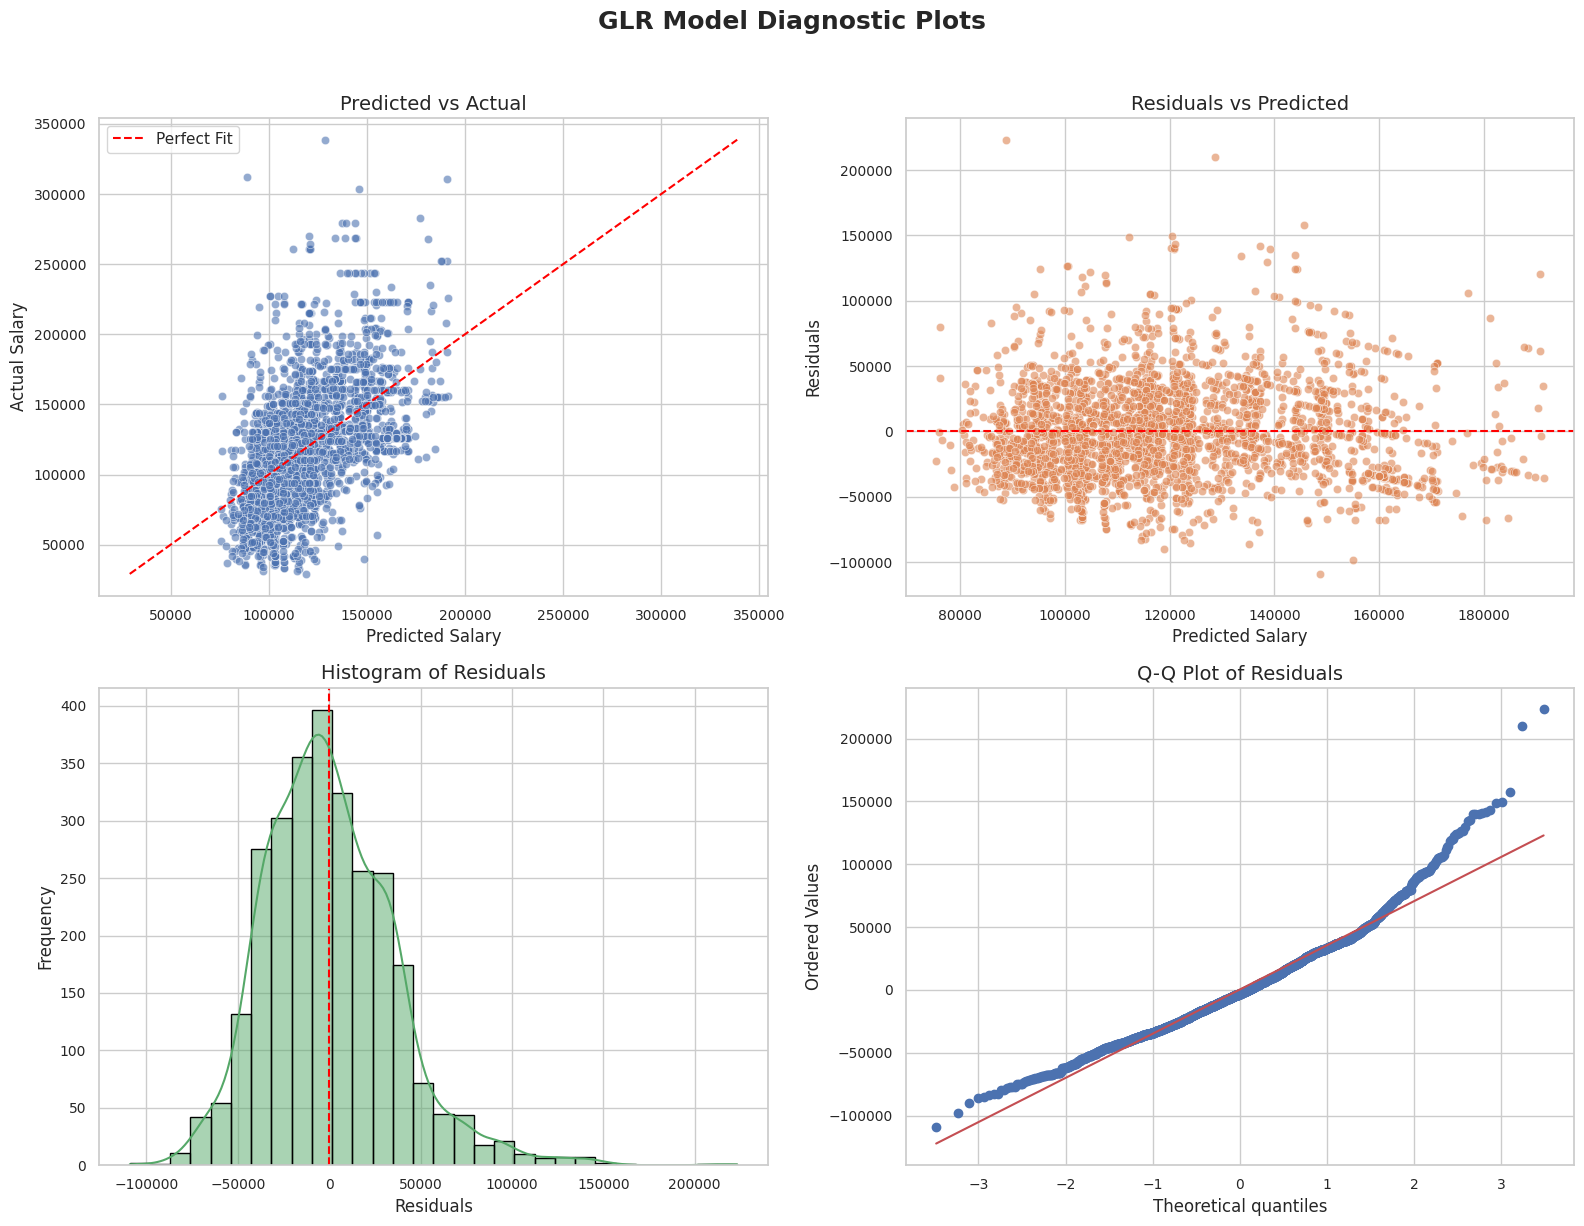

In [27]:
#| eval: true
#| echo: false
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

df_pred = glr_model.transform(test_data).select("prediction", "SALARY").toPandas()
df_pred.dropna(inplace=True)
df_pred["residuals"] = df_pred["SALARY"] - df_pred["prediction"]

sns.set_theme(style="whitegrid", palette="deep")
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "legend.fontsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
})


fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("GLR Model Diagnostic Plots", fontsize=18, fontweight="bold", y=1.02)

# Plot 1: Predicted vs Actual
sns.scatterplot(ax=axes[0, 0], data=df_pred, x="prediction", y="SALARY", alpha=0.6, color="#4C72B0", edgecolor="white")
sns.lineplot(ax=axes[0, 0], x=df_pred["SALARY"], y=df_pred["SALARY"], color="red", linestyle="--", label="Perfect Fit")
axes[0, 0].set_title("Predicted vs Actual")
axes[0, 0].set_xlabel("Predicted Salary")
axes[0, 0].set_ylabel("Actual Salary")
axes[0, 0].legend()

# Plot 2: Residuals vs Predicted
sns.scatterplot(ax=axes[0, 1], data=df_pred, x="prediction", y="residuals", alpha=0.6, color="#DD8452", edgecolor="white")
axes[0, 1].axhline(0, color="red", linestyle="--")
axes[0, 1].set_title("Residuals vs Predicted")
axes[0, 1].set_xlabel("Predicted Salary")
axes[0, 1].set_ylabel("Residuals")

# Plot 3: Histogram of Residuals
sns.histplot(ax=axes[1, 0], data=df_pred, x="residuals", bins=30, kde=True, color="#55A868", edgecolor="black")
axes[1, 0].axvline(0, color="red", linestyle="--")
axes[1, 0].set_title("Histogram of Residuals")
axes[1, 0].set_xlabel("Residuals")
axes[1, 0].set_ylabel("Frequency")

# Plot 4: Q-Q Plot
stats.probplot(df_pred["residuals"], dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of Residuals")

# 布局与保存
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.savefig("_output/glr_diagnostic_plots_customized2.png", dpi=300)
plt.show()

Predicted vs Actual Plot


The scatterplot shows a generally positive relationship between predicted and actual salaries, as expected from a linear regression model.
However, there is noticeable spread around the red dashed line (ideal fit), especially at higher salary ranges.
This suggests the model captures the overall trend but lacks accuracy for extreme salary values.

Residuals vs Predicted Plot

Residuals appear randomly scattered around zero, indicating that the model does not systematically over- or under-predict across the predicted salary range.
However, the vertical spread increases at higher predicted values, suggesting heteroscedasticity.
This violates a key regression assumption of constant error variance and may require transformation or model adjustment.

Histogram of Residuals

The residuals are roughly centered around zero, forming a unimodal distribution.
While the shape is approximately bell-like, the right tail is slightly longer, suggesting mild positive skewness.
This indicates that some predictions are substantially higher than the actual salaries.

Q-Q Plot of Residuals

The Q-Q plot compares residual quantiles to a theoretical normal distribution.
Deviations from the straight line, especially at the tails, show that the residuals are not perfectly normally distributed.
This suggests potential issues with outliers or non-normal error terms, which may impact inference validity.

# Evaluation

The evaluation of the model is crucial to understand its performance. In this section, we will calculate and visualize the following metrics:
1. **R² (Coefficient of Determination)**: Indicates how well the model explains the variance in the target variable.
2. **RMSE (Root Mean Squared Error)**: Measures the average magnitude of the errors between predicted and actual values.

In [31]:
#| eval: true
#| echo: false
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

y_true = df_pred["SALARY"]
y_pred = df_pred["prediction"]


r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")

R²: 0.2954
RMSE: 35699.54


## Model Evaluation Plot

- Display the predicted vs actual salary plot with a red line indicating the ideal fit (y=x).
- Use `seaborn` or `matplotlib` to create the plot.
- Customize the plot with appropriate titles, labels, and legends.
- Describe the plot in a few sentences, highlighting key insights and observations.

In [38]:
summary = glr_model.summary
aic = summary.aic
pred_glr = glr_model.transform(test_data)
n = pred_glr.count()
k = len(glr_model.coefficients) + 1
rss = pred_glr.withColumn("squared_error", pow(col("SALARY") - col("prediction"), 2)) \
              .agg({"squared_error": "sum"}).collect()[0][0]
bic = n * np.log(rss / n) + k * np.log(n)

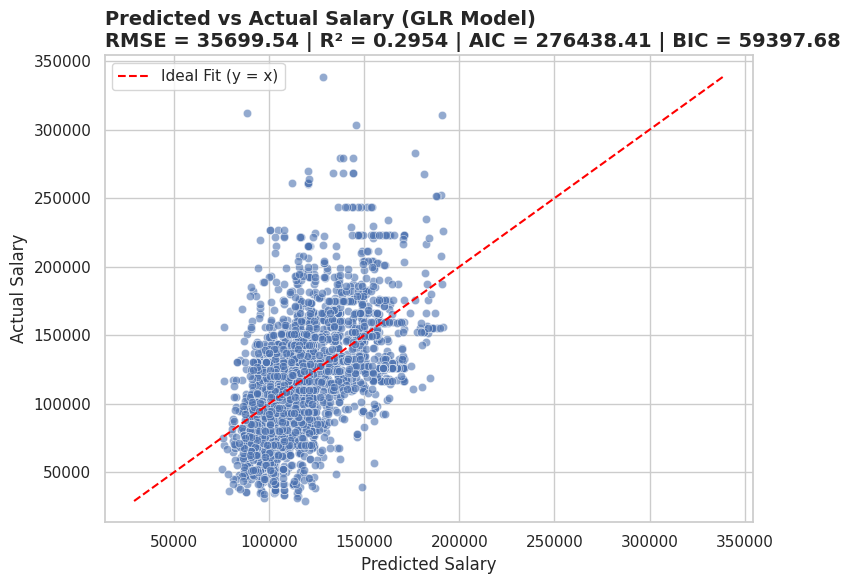

In [39]:
#| eval: true
#| echo: false
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np


pandas_df = glr_model.transform(test_data).select("prediction", "SALARY").toPandas()
pandas_df.dropna(inplace=True)


pandas_df["residuals"] = pandas_df["SALARY"] - pandas_df["prediction"]



plt.figure(figsize=(8, 6))
sns.set_theme(style="whitegrid")

sns.scatterplot(data=pandas_df, x="prediction", y="SALARY", alpha=0.6, color="#4C72B0", edgecolor="white")


min_val = min(pandas_df["prediction"].min(), pandas_df["SALARY"].min())
max_val = max(pandas_df["prediction"].max(), pandas_df["SALARY"].max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label="Ideal Fit (y = x)")


plt.title(f"Predicted vs Actual Salary (GLR Model)\n"
          f"RMSE = {rmse:.2f} | R² = {r2:.4f} | AIC = {aic:.2f} | BIC = {bic:.2f}",
          loc="left", fontsize=14, fontweight="bold")
plt.xlabel("Predicted Salary", fontsize=12)
plt.ylabel("Actual Salary", fontsize=12)
plt.legend()
plt.tight_layout()

plt.savefig("_output/glr_predicted_vs_actual2.png", dpi=300)
plt.show()

The GLR model demonstrates a moderate positive correlation between predicted and actual salaries, with an R² of 0.2954 indicating limited explanatory power.
While the predictions generally follow the ideal fit line, there is noticeable spread, especially at higher salary levels, suggesting potential underfitting or unmodeled variance.

# Submission {.unnumbered}
1. Save figures in the `_output/` folder.
2. Commit and push code and output files:
```bash
git add .
git commit -m "Add Lab 08 Salary Prediction models and output"
git push origin main
```
3. Submit your GitHub repository link.

# Resources {.unnumbered}
- [PySpark MLlib Docs](https://spark.apache.org/docs/latest/ml-guide.html)  
- [Seaborn Docs](https://seaborn.pydata.org/)  
- [Pandas User Guide](https://pandas.pydata.org/docs/user_guide/index.html)
